In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Hanspell, 불용어처리 등 텍스트 전처리가 이미 된 데이터 가져오기
train_df=pd.read_csv("/content/drive/MyDrive/data/train_multi_spellcheck.csv", delimiter=',', encoding='utf-8')
valid_df=pd.read_csv("/content/drive/MyDrive/data/valid_multi_spellcheck.csv", delimiter=',', encoding='utf-8')
test_df=pd.read_csv("/content/drive/MyDrive/data/test_multi_spellcheck.csv", delimiter=',', encoding='utf-8')
train_df.shape, valid_df.shape, test_df.shape

((14981, 12), (3737, 12), (2324, 12))

In [ ]:
train_df.문장 = train_df.문장.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ').str.strip()
train_df.문장.replace('', np.nan, inplace=True)
print(train_df.문장.isna().sum())
train_df.dropna(how='any', inplace=True)
train_df.reset_index(drop=True, inplace=True)
train_df.shape

0


(14981, 12)

In [ ]:
valid_df.문장 = valid_df.문장.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ').str.strip()
valid_df.문장.replace('', np.nan, inplace=True)
print(valid_df.문장.isna().sum())
valid_df.dropna(how='any', inplace=True)
valid_df.reset_index(drop=True, inplace=True)
valid_df.shape

7


(3730, 12)

In [ ]:
test_df.문장 = test_df.문장.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ').str.strip()
test_df.문장.replace('', np.nan, inplace=True)
print(test_df.문장.isna().sum())
test_df.dropna(how='any', inplace=True)
test_df.reset_index(drop=True, inplace=True)
test_df.shape

0


(2324, 12)

### 데이터 전처리
- 레이블링
  - clean인 문장은 1
  - clean이 아닌 문장은 0

In [ ]:
binary_train = train_df.copy()
binary_valid = valid_df.copy()
binary_test = test_df.copy()

In [ ]:
binary_train.loc[binary_train[binary_train.clean == 1].index, '라벨'] = 1
binary_train.loc[binary_train[binary_train.clean != 1].index, '라벨'] = 0

binary_valid.loc[binary_valid[binary_valid.clean == 1].index, '라벨'] = 1
binary_valid.loc[binary_valid[binary_valid.clean != 1].index, '라벨'] = 0

binary_test.loc[binary_test[binary_test.clean == 1].index, '라벨'] = 1
binary_test.loc[binary_test[binary_test.clean != 1].index, '라벨'] = 0

In [ ]:
binary_train = binary_train[['문장', '라벨']]
binary_valid = binary_valid[['문장', '라벨']]
binary_test = binary_test[['문장', '라벨']]

In [ ]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumGothic')

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


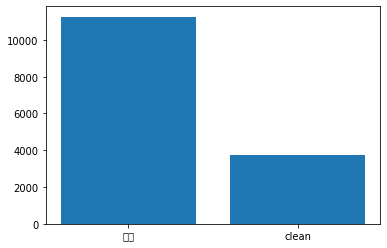

In [ ]:
plt.bar([0, 1], binary_train['라벨'].value_counts())
plt.xticks([0, 1], ['악플', 'clean'])
plt.show()

In [ ]:
# 오버샘플링
from imblearn.over_sampling import RandomOverSampler
binary_train_X, binary_train_y = RandomOverSampler(random_state=0).fit_resample(binary_train['문장'].values.reshape(-1, 1), binary_train['라벨'].values.reshape(-1, 1))

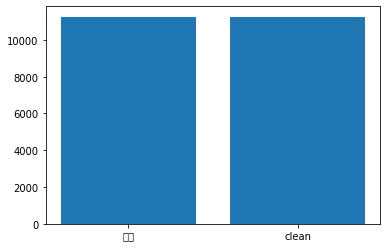

In [ ]:
from collections import Counter
counter = Counter(binary_train_y)
plt.bar(counter.keys(), counter.values())
plt.xticks([0, 1], ['악플', 'clean'])
plt.show()

### 형태소 분석

In [ ]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 453 kB 62.1 MB/s 


In [ ]:
from konlpy.tag import Okt
from tqdm.notebook import tqdm

okt = Okt()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','을','ㅋㅋ','ㅠㅠ','ㅎㅎ']

In [ ]:
X_train = []
for sentence in tqdm(binary_train_X):
  morphs = okt.morphs(sentence[0])
  tmp_X = [word for word in morphs if word not in stopwords]
  X_train.append(tmp_X)

  0%|          | 0/22524 [00:00<?, ?it/s]

In [ ]:
X_valid = []
for sentence in tqdm(binary_valid.문장):
  morphs = okt.morphs(sentence)
  tmp_X = [word for word in morphs if word not in stopwords]
  X_valid.append(tmp_X)

  0%|          | 0/3730 [00:00<?, ?it/s]

In [ ]:
X_test = []
for sentence in tqdm(binary_test.문장):
  morphs = okt.morphs(sentence)
  tmp_X = [word for word in morphs if word not in stopwords]
  X_test.append(tmp_X)

  0%|          | 0/2324 [00:00<?, ?it/s]

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
t = Tokenizer()
t.fit_on_texts(X_train)

threshold = 10
total_cnt = len(t.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in t.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 28096
등장 빈도가 9번 이하인 희귀 단어의 수: 24229
단어 집합에서 희귀 단어의 비율: 86.23647494305239
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 20.327324809613636


In [ ]:
# 모든 단어를 사용하기로 결정
vocab_size = total_cnt + 1
print(vocab_size)

28097


In [ ]:
t = Tokenizer()
t.fit_on_texts(X_train)

X_binary_train = t.texts_to_sequences(X_train)
X_binary_valid = t.texts_to_sequences(X_valid)
X_binary_test = t.texts_to_sequences(X_test)

y_binary_train = binary_train_y
y_binary_valid = binary_valid['라벨'].values
y_binary_test = binary_test['라벨'].values

y_binary_train.shape, y_binary_valid.shape, y_binary_test.shape

((22524,), (3730,), (2324,))

In [ ]:
# 빈 샘플들을 제거
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
X_binary_train = np.delete(X_binary_train, drop_train, axis=0)
y_binary_train = np.delete(y_binary_train, drop_train, axis=0)
print(len(X_binary_train))
print(len(y_binary_train))

22519
22519


### 패딩

리뷰의 최대 길이_Okt ver : 77
리뷰의 평균 길이_Okt ver : 12.711932146187664


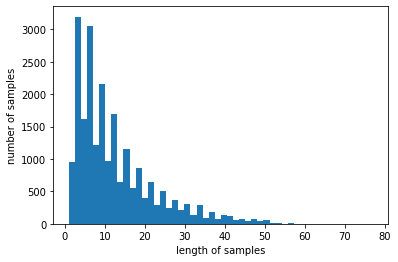

In [ ]:
import matplotlib.pyplot as plt
print('리뷰의 최대 길이_Okt ver :',max(len(review) for review in X_binary_train))
print('리뷰의 평균 길이_Okt ver :',sum(map(len, X_binary_train))/len(X_binary_train))
plt.hist([len(review) for review in X_binary_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [ ]:
max_len = 30
below_threshold_len(max_len, X_binary_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 92.83271903725743


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_binary_train = pad_sequences(X_binary_train, maxlen=max_len)
X_binary_valid = pad_sequences(X_binary_valid, maxlen=max_len)
X_binary_test = pad_sequences(X_binary_test, maxlen=max_len)
X_binary_train.shape, X_binary_valid.shape, X_binary_test.shape

((22519, 30), (3730, 30), (2324, 30))

### 악플 유무 분류 모델 생성

In [ ]:
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
model = Sequential([ 
  Embedding(vocab_size, 128, input_length=max_len),
  SimpleRNN(128, activation='relu'),
  Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 128)           3596416   
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               32896     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 3,629,441
Trainable params: 3,629,441
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_path = 'best-binary.h5'
mc = ModelCheckpoint(model_path, verbose=1, save_best_only=True)
es = EarlyStopping(patience=5)

In [ ]:
hist = model.fit(
    X_binary_train, y_binary_train, validation_data=[X_binary_valid, y_binary_valid],
    epochs=30, batch_size=64, callbacks=[mc, es]
)

Epoch 1/30
352/352 [==============================] - ETA: 0s - loss: 0.3904 - accuracy: 0.8182
Epoch 1: val_loss improved from inf to 1.22212, saving model to best-binary.h5
352/352 [==============================] - 17s 38ms/step - loss: 0.3904 - accuracy: 0.8182 - val_loss: 1.2221 - val_accuracy: 0.6375
Epoch 2/30
351/352 [============================>.] - ETA: 0s - loss: 0.1015 - accuracy: 0.9644
Epoch 2: val_loss did not improve from 1.22212
352/352 [==============================] - 11s 33ms/step - loss: 0.1014 - accuracy: 0.9644 - val_loss: 1.4989 - val_accuracy: 0.6579
Epoch 3/30
352/352 [==============================] - ETA: 0s - loss: 0.0240 - accuracy: 0.9928
Epoch 3: val_loss did not improve from 1.22212
352/352 [==============================] - 12s 34ms/step - loss: 0.0240 - accuracy: 0.9928 - val_loss: 2.8256 - val_accuracy: 0.6584
Epoch 4/30
351/352 [============================>.] - ETA: 0s - loss: 0.0074 - accuracy: 0.9982
Epoch 4: val_loss did not improve from 1.222

In [ ]:
best_model = load_model(model_path)
best_model.evaluate(X_binary_test, y_binary_test)

73/73 [==============================] - 1s 5ms/step - loss: 0.8944 - accuracy: 0.6132


[0.8944021463394165, 0.6131669282913208]

### 악플로 예측되는 데이터만을 가지고 악플 종류 분류

#### 데이터 전처리

In [ ]:
import re
def unsmile_predict(model, new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = t.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  predicted = model.predict(pad_new) # 예측

  return predicted

In [ ]:
X_unsmile_train = []
y_unsmile_train=[]
for i in tqdm(range(len(train_df))):
#for i in range(10000):
  try:
    if unsmile_predict(best_model, train_df.loc[i,'문장']) <= 0.5 :
      X_unsmile_train.append(train_df.loc[i,'문장'])
      y_unsmile_train.append(train_df.loc[i,['여성/가족', '남성', '성소수자', '인종/국적', '연령', '지역', '종교', '기타 혐오', '악플/욕설', '분쟁유발']])
  except:
    pass
    

  0%|          | 0/14981 [00:00<?, ?it/s]

In [ ]:
X_unsmile_train[:10]
print(len(X_unsmile_train))

10613


In [ ]:
len(y_unsmile_train)

10613

#### 데이터 증강

In [ ]:
# import random
# import pickle
# import re

# wordnet = {}
# with open("/content/drive/MyDrive/data/wordnet.pickle", "rb") as f:
# 	wordnet = pickle.load(f)


# # 한글만 남기고 나머지는 삭제
# def get_only_hangul(line):
# 	parseText= re.compile('/ ^[ㄱ-ㅎㅏ-ㅣ가-힣]*$/').sub('',line)

# 	return parseText



# ########################################################################
# # Synonym replacement
# # Replace n words in the sentence with synonyms from wordnet
# ########################################################################
# def synonym_replacement(words, n):
# 	new_words = words.copy()
# 	random_word_list = list(set([word for word in words]))
# 	random.shuffle(random_word_list)
# 	num_replaced = 0
# 	for random_word in random_word_list:
# 		synonyms = get_synonyms(random_word)
# 		if len(synonyms) >= 1:
# 			synonym = random.choice(list(synonyms))
# 			new_words = [synonym if word == random_word else word for word in new_words]
# 			num_replaced += 1
# 		if num_replaced >= n:
# 			break

# 	if len(new_words) != 0:
# 		sentence = ' '.join(new_words)
# 		new_words = sentence.split(" ")

# 	else:
# 		new_words = ""

# 	return new_words


# def get_synonyms(word):
# 	synomyms = []

# 	try:
# 		for syn in wordnet[word]:
# 			for s in syn:
# 				synomyms.append(s)
# 	except:
# 		pass

# 	return synomyms

# ########################################################################
# # Random deletion
# # Randomly delete words from the sentence with probability p
# ########################################################################
# def random_deletion(words, p):
# 	if len(words) == 1:
# 		return words

# 	new_words = []
# 	for word in words:
# 		r = random.uniform(0, 1)
# 		if r > p:
# 			new_words.append(word)

# 	if len(new_words) == 0:
# 		rand_int = random.randint(0, len(words)-1)
# 		return [words[rand_int]]

# 	return new_words

# ########################################################################
# # Random swap
# # Randomly swap two words in the sentence n times
# ########################################################################
# def random_swap(words, n):
# 	new_words = words.copy()
# 	for _ in range(n):
# 		new_words = swap_word(new_words)

# 	return new_words

# def swap_word(new_words):
# 	random_idx_1 = random.randint(0, len(new_words)-1)
# 	random_idx_2 = random_idx_1
# 	counter = 0

# 	while random_idx_2 == random_idx_1:
# 		random_idx_2 = random.randint(0, len(new_words)-1)
# 		counter += 1
# 		if counter > 3:
# 			return new_words

# 	new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1]
# 	return new_words

# ########################################################################
# # Random insertion
# # Randomly insert n words into the sentence
# ########################################################################
# def random_insertion(words, n):
# 	new_words = words.copy()
# 	for _ in range(n):
# 		add_word(new_words)
	
# 	return new_words


# def add_word(new_words):
# 	synonyms = []
# 	counter = 0
# 	while len(synonyms) < 1:
# 		if len(new_words) >= 1:
# 			random_word = new_words[random.randint(0, len(new_words)-1)]
# 			synonyms = get_synonyms(random_word)
# 			counter += 1
# 		else:
# 			random_word = ""

# 		if counter >= 10:
# 			return
		
# 	random_synonym = synonyms[0]
# 	random_idx = random.randint(0, len(new_words)-1)
# 	new_words.insert(random_idx, random_synonym)



# def EDA(sentence, alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1, num_aug=9):
# 	sentence = get_only_hangul(sentence)
# 	words = sentence.split(' ')
# 	words = [word for word in words if word is not ""]
# 	num_words = len(words)

# 	augmented_sentences = []
# 	num_new_per_technique = int(num_aug/4) + 1

# 	n_sr = max(1, int(alpha_sr*num_words))
# 	n_ri = max(1, int(alpha_ri*num_words))
# 	n_rs = max(1, int(alpha_rs*num_words))

# 	# sr
# 	for _ in range(num_new_per_technique):
# 		a_words = synonym_replacement(words, n_sr)
# 		augmented_sentences.append(' '.join(a_words))

# 	# ri
# 	for _ in range(num_new_per_technique):
# 		a_words = random_insertion(words, n_ri)
# 		augmented_sentences.append(' '.join(a_words))

# 	# rs
# 	for _ in range(num_new_per_technique):
# 		a_words = random_swap(words, n_rs)
# 		augmented_sentences.append(" ".join(a_words))

# 	# rd
# 	for _ in range(num_new_per_technique):
# 		a_words = random_deletion(words, p_rd)
# 		augmented_sentences.append(" ".join(a_words))

# 	augmented_sentences = [get_only_hangul(sentence) for sentence in augmented_sentences]
# 	random.shuffle(augmented_sentences)

# 	if num_aug >= 1:
# 		augmented_sentences = augmented_sentences[:num_aug]
# 	else:
# 		keep_prob = num_aug / len(augmented_sentences)
# 		augmented_sentences = [s for s in augmented_sentences if random.uniform(0, 1) < keep_prob]

# 	augmented_sentences.append(sentence)

# 	return augmented_sentences

In [ ]:
# EDA_X_train = []
# EDA_y_train = []
# for i in tqdm(range(len(X_unsmile_train))):
#   eda = EDA(X_unsmile_train[i])
#   for s in eda:
#     EDA_X_train.append(s)

#   for _ in range(len(eda)):
#     EDA_y_train.append(y_unsmile_train[i])

#### 형태소 분석기

In [ ]:
X_train = []
for sentence in tqdm(X_unsmile_train):
  morphs = okt.morphs(sentence, stem=True)
  tmp_X = [word for word in morphs if word not in stopwords]
  X_train.append(tmp_X)

  0%|          | 0/10613 [00:00<?, ?it/s]

In [ ]:
X_valid = []
for sentence in tqdm(valid_df.문장):
  morphs = okt.morphs(sentence)
  tmp_X = [word for word in morphs if word not in stopwords]
  X_valid.append(tmp_X)

  0%|          | 0/3730 [00:00<?, ?it/s]

In [ ]:
X_test = []
for sentence in tqdm(test_df.문장):
  morphs = okt.morphs(sentence, stem=True)
  tmp_X = [word for word in morphs if word not in stopwords]
  X_test.append(tmp_X)

  0%|          | 0/2324 [00:00<?, ?it/s]

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
t = Tokenizer()
t.fit_on_texts(X_train)

threshold = 10
total_cnt = len(t.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in t.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 14838
등장 빈도가 9번 이하인 희귀 단어의 수: 12634
단어 집합에서 희귀 단어의 비율: 85.14624612481467
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 16.916309743989096


In [ ]:
# 토크나이저 저장
# import joblib
# joblib.dump(t, '/content/drive/MyDrive/data/unsmile_tokenizer.pkl')

In [ ]:
# 모든 단어를 사용하기로 결정
vocab_size = total_cnt + 1
print(vocab_size)

14839


In [ ]:
t = Tokenizer(num_words=vocab_size)
t.fit_on_texts(X_train)
X_unsmile_train = t.texts_to_sequences(X_train)
X_unsmile_valid = t.texts_to_sequences(X_valid)
X_unsmile_test = t.texts_to_sequences(X_test)

y_unsmile_train = np.array(y_unsmile_train)
y_unsmile_valid = np.array(valid_df[['여성/가족', '남성', '성소수자', '인종/국적', '연령', '지역', '종교', '기타 혐오', '악플/욕설', '분쟁유발']])
y_unsmile_test = np.array(test_df[['여성/가족', '남성', '성소수자', '인종/국적', '연령', '지역', '종교', '기타 혐오', '악플/욕설', '분쟁유발']])

y_unsmile_train.shape, y_unsmile_valid.shape, y_unsmile_test.shape

((10613, 10), (3730, 10), (2324, 10))

In [ ]:
# 빈 샘플들을 제거
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
X_unsmile_train = np.delete(X_unsmile_train, drop_train, axis=0)
y_unsmile_train = np.delete(y_unsmile_train, drop_train, axis=0)
print(len(X_unsmile_train))
print(len(y_unsmile_train))

10613
10613


#### 패딩

리뷰의 최대 길이_Okt ver : 77
리뷰의 평균 길이_Okt ver : 15.487421087345709


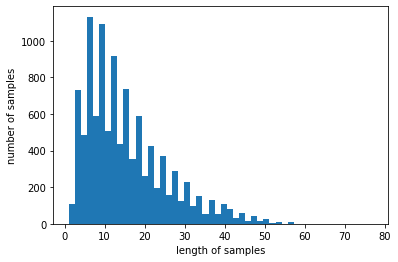

In [ ]:
import matplotlib.pyplot as plt
print('리뷰의 최대 길이_Okt ver :',max(len(review) for review in X_unsmile_train))
print('리뷰의 평균 길이_Okt ver :',sum(map(len, X_unsmile_train))/len(X_unsmile_train))
plt.hist([len(review) for review in X_unsmile_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [ ]:
max_len = 30
below_threshold_len(max_len, X_unsmile_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 90.50221426552342


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_unsmile_train = pad_sequences(X_unsmile_train, maxlen=max_len)
X_unsmile_valid = pad_sequences(X_unsmile_valid, maxlen=max_len)
X_unsmile_test = pad_sequences(X_unsmile_test, maxlen=max_len)
X_unsmile_train.shape, X_unsmile_valid.shape, X_unsmile_test.shape

((10613, 30), (3730, 30), (2324, 30))

#### 모델 생성 및 분류하기

- LSTM

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Conv1D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
model1 = Sequential([ 
    Embedding(vocab_size, 128, input_length=max_len),
    LSTM(128),
    Dense(10, activation='softmax')
])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 30, 128)           1899392   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 2,032,266
Trainable params: 2,032,266
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model1.compile('adam', 'categorical_crossentropy', ['accuracy'])
model1_path = 'unsmile_lstm.h5'
mc1 = ModelCheckpoint(model1_path, verbose=1, save_best_only=True)
es1 = EarlyStopping(patience=5)

In [ ]:
X_unsmile_train = np.asarray(X_unsmile_train).astype(np.float32)
y_unsmile_train = np.asarray(y_unsmile_train).astype(np.float32)

In [ ]:
hist1 = model1.fit(
    X_unsmile_train, y_unsmile_train, validation_data=[X_unsmile_valid, y_unsmile_valid],
    epochs=100, batch_size=64, callbacks=[mc1, es1]
)

Epoch 1/100
159/166 [===========================>..] - ETA: 0s - loss: 2.1781 - accuracy: 0.2597
Epoch 1: val_loss improved from inf to 1.94859, saving model to unsmile_lstm.h5
166/166 [==============================] - 7s 14ms/step - loss: 2.1609 - accuracy: 0.2666 - val_loss: 1.9486 - val_accuracy: 0.1853
Epoch 2/100
162/166 [============================>.] - ETA: 0s - loss: 1.3310 - accuracy: 0.6222
Epoch 2: val_loss did not improve from 1.94859
166/166 [==============================] - 1s 9ms/step - loss: 1.3285 - accuracy: 0.6238 - val_loss: 2.5260 - val_accuracy: 0.1802
Epoch 3/100
159/166 [===========================>..] - ETA: 0s - loss: 0.8974 - accuracy: 0.7734
Epoch 3: val_loss did not improve from 1.94859
166/166 [==============================] - 1s 8ms/step - loss: 0.8968 - accuracy: 0.7742 - val_loss: 3.0190 - val_accuracy: 0.1780
Epoch 4/100
166/166 [==============================] - ETA: 0s - loss: 0.7368 - accuracy: 0.8127
Epoch 4: val_loss did not improve from 1.948

In [ ]:
X_unsmile_test = np.asarray(X_unsmile_test).astype(np.float32)
y_unsmile_test = np.asarray(y_unsmile_test).astype(np.float32)

In [ ]:
best_model1 = load_model(model1_path)
loss1, acc1 = best_model1.evaluate(X_unsmile_test, y_unsmile_test)
loss1, acc1

73/73 [==============================] - 1s 6ms/step - loss: 2.3743 - accuracy: 0.4350


(2.3742728233337402, 0.43502581119537354)

- Conv1D + LSTM

In [ ]:
from keras.layers import Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D

In [ ]:
model2 = Sequential([
    Embedding(vocab_size, 128, input_length=max_len),
    Dropout(0.2),
    Conv1D(256, 3, padding='valid', activation='relu', strides=1),
    MaxPooling1D(pool_size=4),
    LSTM(128),
    Dense(10, activation='softmax')
])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 30, 128)           1899392   
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 conv1d (Conv1D)             (None, 28, 256)           98560     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 7, 256)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                      

In [ ]:
model2.compile('adam', 'categorical_crossentropy', ['accuracy'])
model2_path = 'unsmile_conv1d_lstm.h5'
mc2 = ModelCheckpoint(model2_path, verbose=1, save_best_only=True)
es2 = EarlyStopping(patience=5)

In [ ]:
hist2 = model2.fit(
    X_unsmile_train, y_unsmile_train, validation_data=[X_unsmile_valid, y_unsmile_valid],
    epochs=100, batch_size=64, callbacks=[mc2, es2]
)

Epoch 1/100
166/166 [==============================] - ETA: 0s - loss: 1.9665 - accuracy: 0.3741
Epoch 1: val_loss improved from inf to 2.37189, saving model to unsmile_conv1d_lstm.h5
166/166 [==============================] - 13s 13ms/step - loss: 1.9665 - accuracy: 0.3741 - val_loss: 2.3719 - val_accuracy: 0.1936
Epoch 2/100
159/166 [===========================>..] - ETA: 0s - loss: 0.9819 - accuracy: 0.7438
Epoch 2: val_loss did not improve from 2.37189
166/166 [==============================] - 1s 8ms/step - loss: 0.9773 - accuracy: 0.7443 - val_loss: 3.0019 - val_accuracy: 0.1866
Epoch 3/100
165/166 [============================>.] - ETA: 0s - loss: 0.6923 - accuracy: 0.8214
Epoch 3: val_loss did not improve from 2.37189
166/166 [==============================] - 1s 7ms/step - loss: 0.6935 - accuracy: 0.8213 - val_loss: 3.5599 - val_accuracy: 0.1845
Epoch 4/100
161/166 [============================>.] - ETA: 0s - loss: 0.5461 - accuracy: 0.8601
Epoch 4: val_loss did not improve fr

In [ ]:
best_model2 = load_model(model2_path)
loss2, acc2 = best_model2.evaluate(X_unsmile_test, y_unsmile_test)
loss2, acc2

73/73 [==============================] - 1s 3ms/step - loss: 1.9275 - accuracy: 0.4918


(1.9274927377700806, 0.4918244481086731)

- BiLSTM
  - Embedding Layer
  - Bidirectional LSTM (Dropout: 10%)
  - 1-Dimension Global Max Pooling
  - 1-Dimension Fully Connected Layer
  - Sigmoid Activation

In [ ]:
from tensorflow.keras.layers import Bidirectional, GlobalMaxPooling1D

In [ ]:
model3 = Sequential([
    Embedding(vocab_size, 128, input_length=max_len),
    Bidirectional(LSTM(128, return_sequences=True)),
    GlobalMaxPooling1D(),
    Dense(10, activation='softmax')
])

model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 30, 128)           1899392   
                                                                 
 bidirectional (Bidirectiona  (None, 30, 256)          263168    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 10)                2570      
                                                                 
Total params: 2,165,130
Trainable params: 2,165,130
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model3.compile('adam', 'categorical_crossentropy', ['accuracy'])
model3_path = 'unsmile_bilstm.h5'
mc3 = ModelCheckpoint(model3_path, verbose=1, save_best_only=True)
es3 = EarlyStopping(patience=5)

In [ ]:
hist3 = model3.fit(
    X_unsmile_train, y_unsmile_train, validation_data=[X_unsmile_valid, y_unsmile_valid],
    epochs=100, batch_size=64, callbacks=[mc3, es3]
)

Epoch 1/100
162/166 [============================>.] - ETA: 0s - loss: 2.1132 - accuracy: 0.2987
Epoch 1: val_loss improved from inf to 2.05759, saving model to unsmile_bilstm.h5
166/166 [==============================] - 8s 26ms/step - loss: 2.0980 - accuracy: 0.3043 - val_loss: 2.0576 - val_accuracy: 0.1828
Epoch 2/100
162/166 [============================>.] - ETA: 0s - loss: 1.0998 - accuracy: 0.6993
Epoch 2: val_loss did not improve from 2.05759
166/166 [==============================] - 2s 11ms/step - loss: 1.0953 - accuracy: 0.7001 - val_loss: 2.8201 - val_accuracy: 0.1863
Epoch 3/100
161/166 [============================>.] - ETA: 0s - loss: 0.7935 - accuracy: 0.7945
Epoch 3: val_loss did not improve from 2.05759
166/166 [==============================] - 2s 11ms/step - loss: 0.7939 - accuracy: 0.7940 - val_loss: 3.1256 - val_accuracy: 0.1786
Epoch 4/100
164/166 [============================>.] - ETA: 0s - loss: 0.6962 - accuracy: 0.8150
Epoch 4: val_loss did not improve from 2

In [ ]:
best_model3 = load_model(model3_path)
loss3, acc3 = best_model3.evaluate(X_unsmile_test, y_unsmile_test)
loss3, acc3

73/73 [==============================] - 1s 5ms/step - loss: 2.2269 - accuracy: 0.4880


(2.2268686294555664, 0.4879518151283264)

- Conv1D + BiLSTM

In [ ]:
model4 = Sequential([                 
                     
    Embedding(vocab_size, 128, input_length=max_len),
    Dropout(0.2),
    Conv1D(256, 3, padding='valid', activation='relu', strides=1),
    MaxPooling1D(pool_size=4),
    Bidirectional(LSTM(128, return_sequences=True)),
    GlobalMaxPooling1D(),
    Dense(10, activation='softmax')
])

model4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 30, 128)           1899392   
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 28, 256)           98560     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 7, 256)           0         
 1D)                                                             
                                                                 
 bidirectional_1 (Bidirectio  (None, 7, 256)           394240    
 nal)                                                            
                                                                 
 global_max_pooling1d_1 (Glo  (None, 256)             

In [ ]:
model4.compile('adam', 'categorical_crossentropy', ['accuracy'])
model4_path = 'unsmile_conv1d_bilstm.h5'
mc4 = ModelCheckpoint(model4_path, verbose=1, save_best_only=True)
es4 = EarlyStopping(patience=5)

In [ ]:
hist4 = model4.fit(
    X_unsmile_train, y_unsmile_train, validation_data=[X_unsmile_valid, y_unsmile_valid],
    epochs=100, batch_size=64, callbacks=[mc4, es4]
)

Epoch 1/100
166/166 [==============================] - ETA: 0s - loss: 2.0968 - accuracy: 0.3008
Epoch 1: val_loss improved from inf to 2.17660, saving model to unsmile_conv1d_bilstm.h5
166/166 [==============================] - 8s 24ms/step - loss: 2.0968 - accuracy: 0.3008 - val_loss: 2.1766 - val_accuracy: 0.2011
Epoch 2/100
165/166 [============================>.] - ETA: 0s - loss: 1.1577 - accuracy: 0.6922
Epoch 2: val_loss did not improve from 2.17660
166/166 [==============================] - 2s 10ms/step - loss: 1.1552 - accuracy: 0.6925 - val_loss: 2.8494 - val_accuracy: 0.1925
Epoch 3/100
163/166 [============================>.] - ETA: 0s - loss: 0.7974 - accuracy: 0.7936
Epoch 3: val_loss did not improve from 2.17660
166/166 [==============================] - 2s 10ms/step - loss: 0.7947 - accuracy: 0.7936 - val_loss: 3.3434 - val_accuracy: 0.1727
Epoch 4/100
163/166 [============================>.] - ETA: 0s - loss: 0.6663 - accuracy: 0.8279
Epoch 4: val_loss did not improve

In [ ]:
best_model4 = load_model(model4_path)
loss4, acc4 = best_model4.evaluate(X_unsmile_test, y_unsmile_test)
loss4, acc4

73/73 [==============================] - 1s 4ms/step - loss: 2.5488 - accuracy: 0.5000


(2.5487771034240723, 0.5)

- GRU

In [ ]:
from tensorflow.keras.layers import GRU

In [ ]:
model5 = Sequential([ 
    Embedding(vocab_size, 128, input_length=max_len),
    GRU(128),
    Dense(10, activation='softmax')
])
model5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 30, 128)           1899392   
                                                                 
 gru (GRU)                   (None, 128)               99072     
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
Total params: 1,999,754
Trainable params: 1,999,754
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model5.compile('adam', 'categorical_crossentropy', ['accuracy'])
model5_path = 'unsmile_gru.h5'
mc5 = ModelCheckpoint(model5_path, verbose=1, save_best_only=True)
es5 = EarlyStopping(patience=5)

In [ ]:
hist5 = model5.fit(
    X_unsmile_train, y_unsmile_train, validation_data=[X_unsmile_valid, y_unsmile_valid],
    epochs=100, batch_size=64, callbacks=[mc5, es5]
)

Epoch 1/100
163/166 [============================>.] - ETA: 0s - loss: 2.2053 - accuracy: 0.2562
Epoch 1: val_loss improved from inf to 1.84401, saving model to unsmile_gru.h5
166/166 [==============================] - 4s 14ms/step - loss: 2.2008 - accuracy: 0.2570 - val_loss: 1.8440 - val_accuracy: 0.1909
Epoch 2/100
158/166 [===========================>..] - ETA: 0s - loss: 1.2144 - accuracy: 0.6644
Epoch 2: val_loss did not improve from 1.84401
166/166 [==============================] - 1s 8ms/step - loss: 1.2012 - accuracy: 0.6676 - val_loss: 3.2137 - val_accuracy: 0.1863
Epoch 3/100
162/166 [============================>.] - ETA: 0s - loss: 0.8173 - accuracy: 0.7843
Epoch 3: val_loss did not improve from 1.84401
166/166 [==============================] - 1s 8ms/step - loss: 0.8165 - accuracy: 0.7849 - val_loss: 3.6591 - val_accuracy: 0.1794
Epoch 4/100
158/166 [===========================>..] - ETA: 0s - loss: 0.6895 - accuracy: 0.8264
Epoch 4: val_loss did not improve from 1.8440

In [ ]:
best_model5 = load_model(model5_path)
loss5, acc5 = best_model5.evaluate(X_unsmile_test, y_unsmile_test)
loss5, acc5

73/73 [==============================] - 1s 3ms/step - loss: 2.4951 - accuracy: 0.4656


(2.495100736618042, 0.4655765891075134)

- Conv1D + GRU

In [ ]:
model6 = Sequential([ 
    Embedding(vocab_size, 128, input_length=max_len),
    GRU(128),
    Dense(10, activation='softmax')
])
model6.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 30, 128)           1899392   
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 dense_6 (Dense)             (None, 10)                1290      
                                                                 
Total params: 1,999,754
Trainable params: 1,999,754
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model6.compile('adam', 'categorical_crossentropy', ['accuracy'])
model6_path = 'unsmile_conv1d_gru.h5'
mc6 = ModelCheckpoint(model6_path, verbose=1, save_best_only=True)
es6 = EarlyStopping(patience=5)

In [ ]:
hist6 = model6.fit(
    X_unsmile_train, y_unsmile_train, validation_data=[X_unsmile_valid, y_unsmile_valid],
    epochs=100, batch_size=64, callbacks=[mc6, es6]
)

Epoch 1/100
161/166 [============================>.] - ETA: 0s - loss: 2.2104 - accuracy: 0.2527
Epoch 1: val_loss improved from inf to 1.86176, saving model to unsmile_conv1d_gru.h5
166/166 [==============================] - 4s 14ms/step - loss: 2.2038 - accuracy: 0.2557 - val_loss: 1.8618 - val_accuracy: 0.1794
Epoch 2/100
163/166 [============================>.] - ETA: 0s - loss: 1.2473 - accuracy: 0.6542
Epoch 2: val_loss did not improve from 1.86176
166/166 [==============================] - 2s 10ms/step - loss: 1.2418 - accuracy: 0.6559 - val_loss: 3.1632 - val_accuracy: 0.1796
Epoch 3/100
159/166 [===========================>..] - ETA: 0s - loss: 0.7875 - accuracy: 0.7872
Epoch 3: val_loss did not improve from 1.86176
166/166 [==============================] - 2s 10ms/step - loss: 0.7915 - accuracy: 0.7867 - val_loss: 3.6032 - val_accuracy: 0.1807
Epoch 4/100
164/166 [============================>.] - ETA: 0s - loss: 0.6788 - accuracy: 0.8199
Epoch 4: val_loss did not improve fr

In [ ]:
best_model6 = load_model(model6_path)
loss6, acc6 = best_model6.evaluate(X_unsmile_test, y_unsmile_test)
loss6, acc6

73/73 [==============================] - 1s 3ms/step - loss: 2.7109 - accuracy: 0.4359


(2.710928440093994, 0.435886412858963)

- SelfAttention

In [ ]:
import tensorflow as tf

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads=8):
        super(MultiHeadAttention, self).__init__()
        self.embedding_dim = embedding_dim # d_model
        self.num_heads = num_heads

        assert embedding_dim % self.num_heads == 0

        self.projection_dim = embedding_dim // num_heads
        self.query_dense = tf.keras.layers.Dense(embedding_dim)
        self.key_dense = tf.keras.layers.Dense(embedding_dim)
        self.value_dense = tf.keras.layers.Dense(embedding_dim)
        self.dense = tf.keras.layers.Dense(embedding_dim)

    def scaled_dot_product_attention(self, query, key, value):
        matmul_qk = tf.matmul(query, key, transpose_b=True)
        depth = tf.cast(tf.shape(key)[-1], tf.float32)
        logits = matmul_qk / tf.math.sqrt(depth)
        attention_weights = tf.nn.softmax(logits, axis=-1)
        output = tf.matmul(attention_weights, value)
        return output, attention_weights

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]

        # (batch_size, seq_len, embedding_dim)
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        # (batch_size, num_heads, seq_len, projection_dim)
        query = self.split_heads(query, batch_size)  
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        scaled_attention, _ = self.scaled_dot_product_attention(query, key, value)
        # (batch_size, seq_len, num_heads, projection_dim)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  

        # (batch_size, seq_len, embedding_dim)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.embedding_dim))
        outputs = self.dense(concat_attention)
        return outputs

In [ ]:
# 인코더 설계
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads, dff, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(embedding_dim, num_heads)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(dff, activation="relu"),
             tf.keras.layers.Dense(embedding_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs) # 첫번째 서브층 : 멀티 헤드 어텐션
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output) # Add & Norm
        ffn_output = self.ffn(out1) # 두번째 서브층 : 포지션 와이즈 피드 포워드 신경망
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output) # Add & Norm

In [ ]:
# 포지션 임베딩
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, max_len, vocab_size, embedding_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.pos_emb = tf.keras.layers.Embedding(max_len, embedding_dim)

    def call(self, x):
        max_len = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=max_len, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
embedding_dim = 32  # 각 단어의 임베딩 벡터의 차원
num_heads = 2  # 어텐션 헤드의 수
dff = 32  # 포지션 와이즈 피드 포워드 신경망의 은닉층의 크기

inputs = tf.keras.layers.Input(shape=(max_len,))
embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embedding_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embedding_dim, num_heads, dff)
x = transformer_block(x)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(20, activation="relu")(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = tf.keras.layers.Dense(10, activation="softmax")(x)

model7 = tf.keras.Model(inputs=inputs, outputs=outputs)
model7.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 token_and_position_embeddin  (None, 30, 32)           475808    
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 transformer_block (Transfor  (None, 30, 32)           6464      
 merBlock)                                                       
                                                                 
 global_max_pooling1d_2 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_4 (Dropout)         (None, 32)                0     

In [ ]:
model7.compile("adam", "categorical_crossentropy", metrics=["accuracy"])
model7_path = 'best-transforemr-attention.h5py'
mc7 = ModelCheckpoint(model7_path, verbose=1, save_best_only=True)
es7 = EarlyStopping(patience=5)

history7 = model7.fit(X_unsmile_train, y_unsmile_train, batch_size=64, epochs=100, validation_data=[X_unsmile_valid, y_unsmile_valid], callbacks=[mc7, es7])

Epoch 1/100
166/166 [==============================] - ETA: 0s - loss: 2.4421 - accuracy: 0.1550
Epoch 1: val_loss improved from inf to 1.80946, saving model to best-transforemr-attention.h5py


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


166/166 [==============================] - 12s 49ms/step - loss: 2.4421 - accuracy: 0.1550 - val_loss: 1.8095 - val_accuracy: 0.1826
Epoch 2/100
166/166 [==============================] - ETA: 0s - loss: 1.9067 - accuracy: 0.4011
Epoch 2: val_loss did not improve from 1.80946
166/166 [==============================] - 1s 8ms/step - loss: 1.9067 - accuracy: 0.4011 - val_loss: 2.2196 - val_accuracy: 0.1855
Epoch 3/100
163/166 [============================>.] - ETA: 0s - loss: 1.4430 - accuracy: 0.6048
Epoch 3: val_loss did not improve from 1.80946
166/166 [==============================] - 1s 8ms/step - loss: 1.4436 - accuracy: 0.6046 - val_loss: 2.9885 - val_accuracy: 0.1839
Epoch 4/100
166/166 [==============================] - ETA: 0s - loss: 1.7569 - accuracy: 0.6222
Epoch 4: val_loss did not improve from 1.80946
166/166 [==============================] - 1s 8ms/step - loss: 1.7569 - accuracy: 0.6222 - val_loss: 3.4796 - val_accuracy: 0.1836
Epoch 5/100
165/166 [=====================

In [ ]:
best_model7 = load_model(model7_path)
loss7, acc7 = best_model7.evaluate(X_unsmile_test, y_unsmile_test)
loss7, acc7

73/73 [==============================] - 1s 4ms/step - loss: 1.5409 - accuracy: 0.3472


(1.540872573852539, 0.3472461402416229)

- BiLSTM with Attention

In [ ]:
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, GlobalMaxPooling1D, Dropout, Concatenate, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)

  def call(self, values, query): # 단, key와 value는 같음
    # query shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # score 계산을 위해 뒤에서 할 덧셈을 위해서 차원을 변경해줍니다.
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
sequence_input = Input(shape=(max_len,), dtype='int32')
embedded_sequences = Embedding(vocab_size, 128, input_length=max_len, mask_zero = True)(sequence_input)
lstm = Bidirectional(LSTM(64, dropout=0.5, return_sequences = True))(embedded_sequences)
lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional \
  (LSTM(64, dropout=0.5, return_sequences=True, return_state=True))(lstm)
state_h = Concatenate()([forward_h, backward_h]) # 은닉 상태
state_c = Concatenate()([forward_c, backward_c]) # 셀 상태
attention = BahdanauAttention(64) # 가중치 크기 정의
context_vector, attention_weights = attention(lstm, state_h)
dense1 = Dense(20, activation="relu")(context_vector)
dropout = Dropout(0.5)(dense1)
output = Dense(10, activation="softmax")(dropout)
model8 = Model(inputs=sequence_input, outputs=output)
model8.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 embedding_9 (Embedding)        (None, 30, 128)      1899392     ['input_2[0][0]']                
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 30, 128)     98816       ['embedding_9[0][0]']            
 )                                                                                                
                                                                                                  
 bidirectional_3 (Bidirectional  [(None, 30, 128),   98816       ['bidirectional_2[0][0]']  

In [ ]:
model8.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model8_path = 'best-lstm-attention.h5py'
mc8 = ModelCheckpoint(model8_path, verbose=1, save_best_only=True)
es8 = EarlyStopping(patience=5)

In [ ]:
hist8 = model8.fit(X_unsmile_train, y_unsmile_train, epochs = 100, batch_size = 64, 
                     validation_data=[X_unsmile_valid, y_unsmile_valid], verbose=1, 
                     callbacks=[mc8, es8])

Epoch 1/100
166/166 [==============================] - ETA: 0s - loss: 2.2731 - accuracy: 0.2193
Epoch 1: val_loss improved from inf to 1.86306, saving model to best-lstm-attention.h5py


INFO:tensorflow:Assets written to: best-lstm-attention.h5py/assets


INFO:tensorflow:Assets written to: best-lstm-attention.h5py/assets


166/166 [==============================] - 246s 1s/step - loss: 2.2731 - accuracy: 0.2193 - val_loss: 1.8631 - val_accuracy: 0.1946
Epoch 2/100
166/166 [==============================] - ETA: 0s - loss: 1.7913 - accuracy: 0.4412
Epoch 2: val_loss did not improve from 1.86306
166/166 [==============================] - 53s 317ms/step - loss: 1.7913 - accuracy: 0.4412 - val_loss: 2.5736 - val_accuracy: 0.1651
Epoch 3/100
166/166 [==============================] - ETA: 0s - loss: 1.6612 - accuracy: 0.5623
Epoch 3: val_loss did not improve from 1.86306
166/166 [==============================] - 53s 318ms/step - loss: 1.6612 - accuracy: 0.5623 - val_loss: 3.5842 - val_accuracy: 0.1751
Epoch 4/100
166/166 [==============================] - ETA: 0s - loss: 1.8994 - accuracy: 0.6355
Epoch 4: val_loss did not improve from 1.86306
166/166 [==============================] - 53s 318ms/step - loss: 1.8994 - accuracy: 0.6355 - val_loss: 5.5212 - val_accuracy: 0.1772
Epoch 5/100
166/166 [=============

In [ ]:
best_model8 = load_model(model8_path)
loss8, acc8 = best_model8.evaluate(X_unsmile_test, y_unsmile_test)
loss8, acc8

73/73 [==============================] - 7s 37ms/step - loss: 1.5103 - accuracy: 0.4540


(1.510287880897522, 0.4539586901664734)

- 정확도 비교

In [ ]:
print(f"LSTM : {loss1} / {acc1}")
print(f"Conv1D + LSTM : {loss2} / {acc2}")
print(f"BiLSTM : {loss3} / {acc3}")
print(f"Conv1D + BiLSTM : {loss4} / {acc4}")
print(f"GRU : {loss5} / {acc5}")
print(f"Conv1D + GRU : {loss6} / {acc6}")
print(f"SelfAttention : {loss7} / {acc7}")
print(f"BiLSTM with Attetion : {loss8} / {acc8}")

LSTM : 2.3742728233337402 / 0.43502581119537354
Conv1D + LSTM : 1.9274927377700806 / 0.4918244481086731
BiLSTM : 2.2268686294555664 / 0.4879518151283264
Conv1D + BiLSTM : 2.5487771034240723 / 0.5
GRU : 2.495100736618042 / 0.4655765891075134
Conv1D + GRU : 2.710928440093994 / 0.435886412858963
SelfAttention : 1.540872573852539 / 0.3472461402416229
BiLSTM with Attetion : 1.510287880897522 / 0.4539586901664734
